# Keras
Librería para programar redes neuronales de una manera más sencilla que con TensorFlow. Keras se encuentra en una capa de abstracción por encima de TensorFlow.

[Documentación](https://keras.io/guides/)

In [1]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Ruta de logs (usa fecha para evitar sobrescribir)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [2]:
#!pip install tensorflow --user
#!pip install keras --user


Empezamos importando librerías

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np

Cargamos los datos de mnist. No vamos a tratar imagenes con redes convolucionales (perdemos la estructura espacial 2D). Todos los pixeles se convertirán en un vector de 28x28 features independientes, que serán las entradas del modelo.

In [4]:
# Cogemos las imágenes de los dígitos asi como el conjunto de train y test
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

Vemos dimensiones del dataset

In [5]:
'''
60.000 imagenes de 28x28 pixeles
'''
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [6]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

60.000 imágenes de 28x28 pixeles. Vamos a representar una de ellas

C:\Users\yporq\AppData\Local\Temp\ipykernel_45412\3096108358.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(X_train[0], cmap=plt.cm.get_cmap('Greys'));


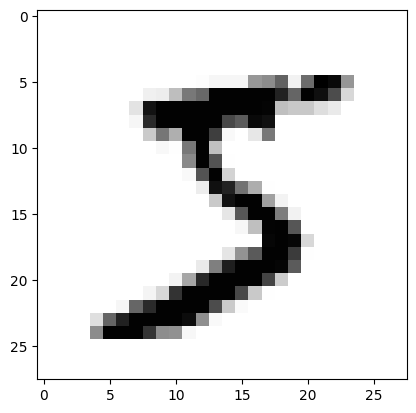

In [7]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0], cmap=plt.cm.get_cmap('Greys'));

Cada imagen se compone de 28x28 pixeles, y cada pixel representa una escala de grises que va del 0 al 255. Siendo 0 el blanco y 255 negro.

¿Se te ocurre alguna manera de normalizar los datos?

In [8]:
0/255

0.0

In [9]:
128/255

0.5019607843137255

In [10]:
255/255

1.0

In [11]:
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

In [12]:
np.mean(X_train)

0.13066062

In [13]:
'''
Comprobamos la normalización
'''
X_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [14]:
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

Guardamos datos para validación. Estos datos se usarán durante el entrenamiento. Otra opción es decirle a keras en la etapa de entrenamiento que reserve un X % de los datos para validar.

In [15]:
X_val = X_train[-10000:]
y_val = y_train[-10000:]

X_train = X_train[:-10000]
y_train = y_train[:-10000]

In [16]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


Montamos la arquitectura de la red neuronal. Se va a componer de:
* **Sequential**: API para iniciar la red neuronal. No cuenta como capa.
* **Flatten**: capa de entrada. Necesita un vector unidimensional. Como tenemos imágenes, esta capa aplana las imagenes (2D) en 1D.
* **Dense**: es una hidden layer. Se compondrá de `n` neuronas y de una función de activación que se aplicará a todas las neuronas de la capa.

Recuerda que es un problema de clasificación multiclase (10 clases) y que por tanto la última capa se compondrá de tantas neuronas como clases tengas.

En cuanto a las funciones de activación es recomendable usar relu en las hidden layer, que tarda menos en entrenar, mientras que la ultima (output) suele ser una softmax.

In [17]:
model = keras.models.Sequential()

# Capa entrada
model.add(keras.layers.Flatten(input_shape=(28, 28)))

# Hidden layer
model.add(keras.layers.Dense(units = 300,
                            activation='relu'))

# Hidden layer
model.add(keras.layers.Dense(units = 100,
                            activation='relu'))

# Capa salida
model.add(keras.layers.Dense(units = 10,
                            activation='softmax'))

c:\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Otra manera de declarar la red neuronal
capas = [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(units = 300, activation='relu'),
    keras.layers.Dense(units = 100, activation='relu'),
    keras.layers.Dense(units = 10, activation='softmax')
]

model = keras.models.Sequential(capas)

Podemos ver las capas, y acceder a sus elementos

In [19]:
print(model.layers[0])

<Flatten name=flatten_1, built=True>


Podemos ver los pesos de las capas sin entrenar, porque los inicializa aleatoriamente. Los bias los inicializa a 0.

In [20]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()

In [21]:
weights.shape

(784, 300)

In [22]:
#weights

In [23]:
28*28

784

In [24]:
len(weights[0])

300

In [25]:
28*28

784

In [26]:
300*784

235200

In [27]:
weights.size

235200

In [28]:
biases[:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

Establecemos la configuración de ejecución... el compile.

In [29]:
model.compile(
    optimizer = keras.optimizers.SGD(),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)

In [30]:
# Equivalente
model.compile(
    optimizer = "sgd",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [31]:
784*300 + 300

235500

In [32]:
# Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
300*28*28 + 300


235500

Entrenamos el modelo. Usamos los datos de entrenamiento. El batch_size es la cantidad de muestras que utiliza el SGD, y las epochs son las iteraciones que realiza en el entrenamiento.

In [34]:
X_train.shape

(50000, 28, 28)

In [35]:
50000/128

390.625

In [36]:
50000/128

390.625

In [38]:
history = model.fit(
    X_train,
    y_train,
    batch_size = 128,
    epochs = 50,
    validation_data = (X_val, y_val), # validation_split = 0.1
    callbacks=[tensorboard_callback] #aquí guardamos los datos de entrenamiento(loss, accuracy, val_loss... en logs/fit/)
)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5007 - loss: 1.7575 - val_accuracy: 0.8653 - val_loss: 0.5885
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8625 - loss: 0.5649 - val_accuracy: 0.8977 - val_loss: 0.3883
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8908 - loss: 0.4036 - val_accuracy: 0.9095 - val_loss: 0.3297
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9049 - loss: 0.3454 - val_accuracy: 0.9158 - val_loss: 0.2992
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9112 - loss: 0.3161 - val_accuracy: 0.9218 - val_loss: 0.2769
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9191 - loss: 0.2913 - val_accuracy: 0.9260 - val_loss: 0.2624
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9210 - loss: 0.2801 - val_accuracy: 0.9311 - val_loss: 0.2470
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9260 - loss: 0.2633 - val_accuracy: 0.

Podemos reentrenar el modelo. No empieza de nuevo, sino que retoma el entrenamiento anterior.

In [ ]:
model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs = 10,
    validation_data = (X_val, y_val) # validation_split = 0.1
)

Epoch 1/10


782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9771 - loss: 0.0827 - val_accuracy: 0.9699 - val_loss: 0.1053
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9779 - loss: 0.0798 - val_accuracy: 0.9699 - val_loss: 0.1066
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9790 - loss: 0.0779 - val_accuracy: 0.9708 - val_loss: 0.1023
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9788 - loss: 0.0799 - val_accuracy: 0.9717 - val_loss: 0.0996
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9789 - loss: 0.0746 - val_accuracy: 0.9708 - val_loss: 0.1006
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9806 - loss: 0.0713 - val_accuracy: 0.9714 - val_loss: 0.0976
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9822 - loss: 0.0687 - val_accuracy: 0.9725 - val_loss: 0.0959
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9828 - loss: 0.0664 - val_accuracy: 0.9729 - val_

Veamos el histórico del entrenamiento, para poder representarlo posteriormente.

In [ ]:
print(history.params)
print(history.epoch)
history.history

{'verbose': 'auto', 'epochs': 50, 'steps': 391}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


{'accuracy': [0.7161399722099304,
  0.8769199848175049,
  0.8958799839019775,
  0.9057000279426575,
  0.912339985370636,
  0.9175999760627747,
  0.921019971370697,
  0.9248999953269958,
  0.9285200238227844,
  0.9312800168991089,
  0.9343799948692322,
  0.9371200203895569,
  0.9395400285720825,
  0.9415599703788757,
  0.9437199831008911,
  0.9451199769973755,
  0.9464399814605713,
  0.9483799934387207,
  0.9502599835395813,
  0.9513999819755554,
  0.9531400203704834,
  0.9543399810791016,
  0.9553400278091431,
  0.9563400149345398,
  0.9576600193977356,
  0.9591400027275085,
  0.9602400064468384,
  0.9611799716949463,
  0.9623200297355652,
  0.96315997838974,
  0.9641000032424927,
  0.9648200273513794,
  0.9658600091934204,
  0.9665600061416626,
  0.9674999713897705,
  0.9676799774169922,
  0.9687399864196777,
  0.968999981880188,
  0.9700199961662292,
  0.9708799719810486,
  0.971560001373291,
  0.9719200134277344,
  0.9723600149154663,
  0.9732999801635742,
  0.9736999869346619,
  0.

In [ ]:
history.history

{'accuracy': [0.7161399722099304,
  0.8769199848175049,
  0.8958799839019775,
  0.9057000279426575,
  0.912339985370636,
  0.9175999760627747,
  0.921019971370697,
  0.9248999953269958,
  0.9285200238227844,
  0.9312800168991089,
  0.9343799948692322,
  0.9371200203895569,
  0.9395400285720825,
  0.9415599703788757,
  0.9437199831008911,
  0.9451199769973755,
  0.9464399814605713,
  0.9483799934387207,
  0.9502599835395813,
  0.9513999819755554,
  0.9531400203704834,
  0.9543399810791016,
  0.9553400278091431,
  0.9563400149345398,
  0.9576600193977356,
  0.9591400027275085,
  0.9602400064468384,
  0.9611799716949463,
  0.9623200297355652,
  0.96315997838974,
  0.9641000032424927,
  0.9648200273513794,
  0.9658600091934204,
  0.9665600061416626,
  0.9674999713897705,
  0.9676799774169922,
  0.9687399864196777,
  0.968999981880188,
  0.9700199961662292,
  0.9708799719810486,
  0.971560001373291,
  0.9719200134277344,
  0.9723600149154663,
  0.9732999801635742,
  0.9736999869346619,
  0.

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
pd.DataFrame(history.history)

,accuracy,loss,val_accuracy,val_loss
0,0.71614,1.209493,0.8791,0.572315
1,0.87692,0.497557,0.9029,0.382398
2,0.89588,0.387567,0.9123,0.325338
3,0.90570,0.342327,0.9169,0.299139
4,0.91234,0.314604,0.9238,0.277143
5,0.91760,0.294162,0.9275,0.262724
6,0.92102,0.277955,0.9286,0.251337
7,0.92490,0.264357,0.9330,0.239801
8,0.92852,0.252342,0.9359,0.230623
9,0.93128,0.241657,0.9382,0.221915


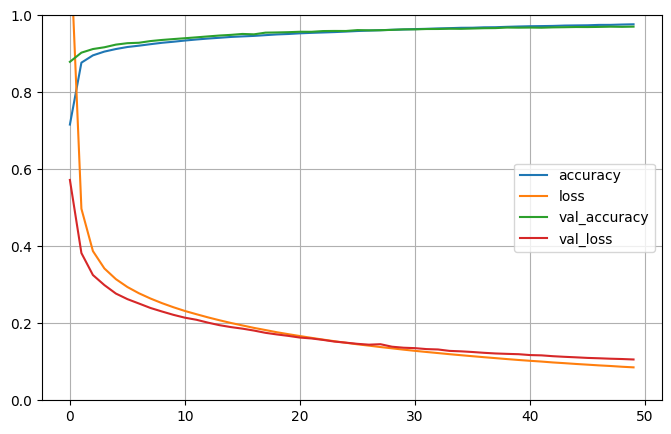

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Si el modelo no ha ido bien, prueba a cambiar el learning rate, cambia de optimizador y después prueba a cambiar capas, neuronas y funciones de activación.

Ya tenemos el modelo entrenado. Probémoslo con test

In [ ]:
results = model.evaluate(X_test, y_test)
results

 46/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0734

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9691 - loss: 0.1051


[0.09018586575984955, 0.9729999899864197]

C:\Users\yporq\AppData\Local\Temp\ipykernel_48228\1468152043.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(X_test[0].reshape(28,28), cmap=plt.cm.get_cmap('Greys'));


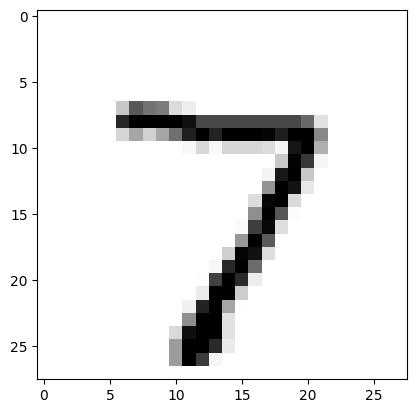

In [ ]:
# Cogemos el primero
plt.imshow(X_test[0].reshape(28,28), cmap=plt.cm.get_cmap('Greys'));

In [ ]:
X_test[:1]

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.

In [ ]:
predictions = model.predict(X_test[:1]).round(3)
print(predictions.shape)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
(1, 10)


array([[0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.998, 0.   ,
        0.   ]], dtype=float32)

In [ ]:
predictions.argmax()

7

In [ ]:
model.predict(X_test).argmax(axis=1)

  1/313 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [ ]:
y_test[0]

7.0

C:\Users\yporq\AppData\Local\Temp\ipykernel_48228\1084033691.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(X_test[2].reshape(28,28), cmap=plt.cm.get_cmap('Greys'));


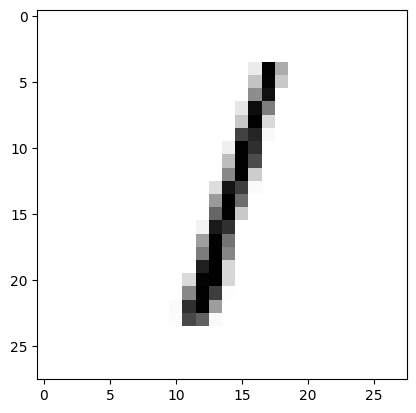

In [ ]:
plt.imshow(X_test[2].reshape(28,28), cmap=plt.cm.get_cmap('Greys'));

### Problema de regresión
Veamos un ejemplo de cómo aplicar una red neuronal de TensorFlow a un problema de regresión.

In [ ]:
#housing.keys()

In [ ]:
# Cargamos datos
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns = housing.feature_names)
df['target'] = housing['target']
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Divimos en train, test y validation

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data,
                                                              housing.target)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                      y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

(11610, 8)

In [ ]:
print(np.any(np.isnan(X_train)))
print(np.any(np.isnan(X_valid)))
print(np.any(np.isnan(X_test)))

False
False
False


Montamos el modelo. Simplemente se compondrá de una hidden layer, a la que le configuramos una capa previa de entrada de 8 neuronas (las features).

Se trata de un modelo de regresión, por lo que la capa de salida es una única neurona.

In [ ]:
X_train.shape

(11610, 8)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'relu',
                      input_shape = X_train.shape[1:]),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(clipnorm=1)

model.compile(loss = "mean_squared_error",
             optimizer = optimizer) # con optimizer = "sgd" aparece la explosión del gradiente y nan's 

history = model.fit(X_train,
                   y_train,
                   epochs = 20,
                   validation_data = (X_valid, y_valid))

Epoch 1/20


c:\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5032 - val_loss: 0.5258
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5215 - val_loss: 0.4713
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4717 - val_loss: 0.4465
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4510 - val_loss: 0.4268
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4310 - val_loss: 0.4203
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4475 - val_loss: 0.4122
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4114 - val_loss: 0.4065
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4046 - val_loss: 0.4018
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3818 - val_loss: 0.3957
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3750 - val_loss: 0.4000
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3660 - val_loss: 0.3912
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.

In [ ]:
8*30 + 30

270

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 30)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303 (1.19 KB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
mse_test = model.evaluate(X_test, y_test)
print(mse_test)

101/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4227

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4180
0.3981248438358307


In [ ]:
y_pred = model.predict(X_test[:5])
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


array([[3.6899045],
       [1.0790904],
       [0.9624312],
       [1.9782822],
       [1.6492631]], dtype=float32)

### Guardar modelo
Para guardar el modelo, en el formato de Keras (HDF5). 

In [ ]:
model.save("my_keras_model.h5")

In [ ]:
# Lo volvemos a cargar
model = keras.models.load_model("my_keras_model.h5")

### Callbacks
Son funciones predefinidas de Keras a aplicar durante el entrenamiento
Por ejemplo, `ModelCheckpoint` sirve para que el modelo se vaya guardando tras cada epoch. Así no perdemos el progreso en caso de que decidamos interrumpir el entrenamiento. El callback recibe como argumento el nombre del objeto donde queremos que se guarde el modelo entrenado.

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("callback_model.h5")
history = model.fit(X_train,
                   y_train,
                   epochs=30,
                   callbacks = [checkpoint_cb])

Epoch 1/30


NotImplementedError: numpy() is only available when eager execution is enabled.

### Early Stopping
Interrumpe el entrenamiento cuando no ve progreso en el set de validación. Para ello tiene en cuenta un numero de epochs llamado `patience`. Se puede combinar con el callback

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)
history = model.fit(X_train,
                   y_train,
                   epochs=20,
                    validation_data = (X_valid, y_valid),
                   callbacks = [early_stopping_cb])

Epoch 1/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3366 - val_loss: 0.3556
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3356 - val_loss: 0.3625
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3352 - val_loss: 0.3562
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3349 - val_loss: 0.3583
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3341 - val_loss: 0.3520
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3328 - val_loss: 0.3556
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3327 - val_loss: 0.3512
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3327 - val_loss: 0.3579
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3324 - val_loss: 0.3559
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3309 - val_loss: 0.3505